**Imports**

In [1]:
import json
from pprint import pprint
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pathlib import Path

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Constructing the basic dataset

In [3]:
data_folder = Path('../data/twint')
tweets_file = data_folder / '2019_april_may_#uber_EN.txt'

In [4]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()

In [5]:
tweets = [json.loads(l) for l in lines]
print(tweets[0])

{'id': 1134217832886149120, 'conversation_id': '1134217832886149120', 'created_at': 1559253578000, 'date': '2019-05-30', 'time': '23:59:38', 'timezone': '+0200', 'user_id': 803710812649033728, 'username': 'rokk3rfuel', 'name': 'Rokk3r Fuel ExO', 'place': '', 'tweet': '"The question prospective investors have to ask themselves about #Uber is not how much the stock has dipped since the #IPO, but do they think @Uber will be successful 10 years from now," says Managing Director of Rokk3r Fuel @LPFocused @CNBCClosingBell https://cnb.cx/2YRrRFw\xa0', 'mentions': ['uber', 'cnbcclosingbell'], 'urls': ['https://cnb.cx/2YRrRFw'], 'photos': [], 'replies_count': 0, 'retweets_count': 0, 'likes_count': 11, 'hashtags': ['#uber', '#ipo'], 'cashtags': [], 'link': 'https://twitter.com/Rokk3rFuel/status/1134217832886149120', 'retweet': False, 'quote_url': '', 'video': 0, 'near': '', 'geo': '', 'source': '', 'user_rt_id': '', 'user_rt': '', 'retweet_id': '', 'reply_to': [{'user_id': '803710812649033728', 

In [6]:
print('Number of tweets:\t%s' % len(tweets))

Number of tweets:	38493


## Top 20 Hashtags

In [7]:
hashtags = [h for t in tweets for h in t['hashtags']]

In [8]:
from collections import Counter
hashtags_count = pd.DataFrame.from_dict(Counter(hashtags), orient='index', columns=['count']).sort_values(by='count', ascending=False)[:20]
hashtags_count

,count
#uber,39109
#lyft,8089
#taxi,2499
#ipo,2028
#tfl,1503
#uk,1492
#rideshare,1380
#crypto,1282
#np,1248
#edm,1240


## Tweet Time Distribution

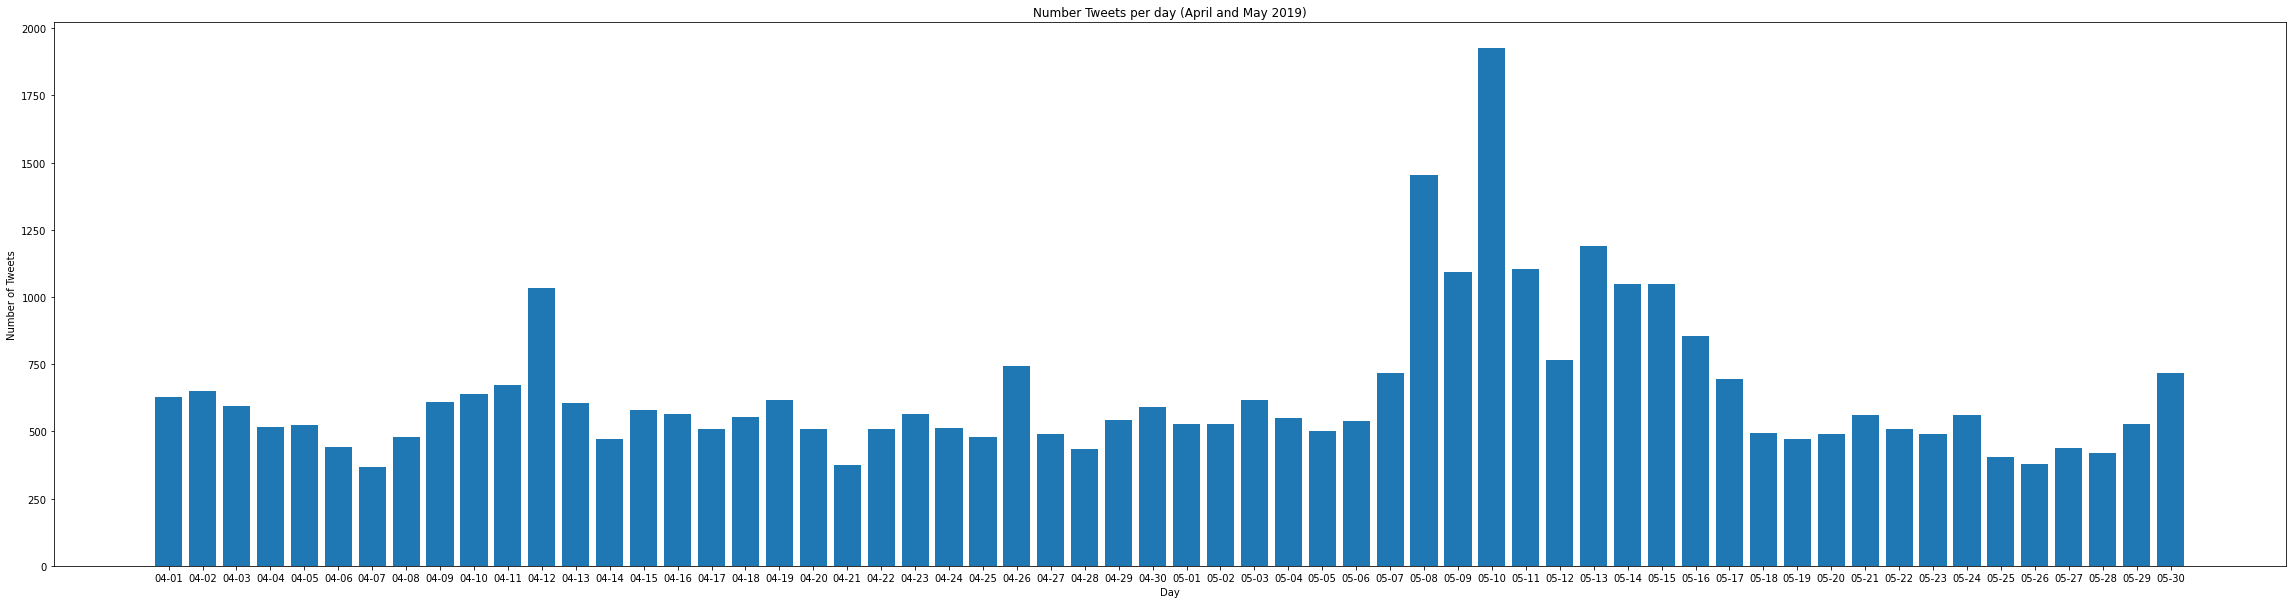

In [9]:
dates_to_n_tweets = {}

for t in tweets:
    date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
    try:
        dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
    except:
        dates_to_n_tweets[date] = 0

sorted_dates = sorted(dates_to_n_tweets.items())
plt.figure(1, figsize=(40, 10))
plt.bar([e[0] for e in sorted_dates], [e[1] for e in sorted_dates])
plt.title('Number Tweets per day (April and May 2019)')
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.show()

# Text preparation

In [10]:
stop_words = stopwords.words('english')
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

In [11]:
def word_tokenize(tweet):
    return tokenizer.tokenize(tweet)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_tweet_text(tweet):
    
    tweet = tweet.lower()
    #Remove numbers
    tweet = re.sub(r"[0-9]", '', tweet, flags=re.MULTILINE)
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tweet_tokens = word_tokenize(tweet)
    # Remove non-alpha words
    filtered_words = [w for w in tweet_tokens if w.isalpha()]
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    lemma_words = [lemmatizer.lemmatize(w, pos=get_wordnet_pos(w)) for w in filtered_words]
    
    # Filter out short lemmas
    lemma_words = [w for w in lemma_words if len(w) > 2]
    
    return lemma_words

In [12]:
unique_usernames = {t['username'] for t in tweets}
users_to_documents = {u:[] for u in unique_usernames}

for tw in tweets:
    u = tw['username']
    t = preprocess_tweet_text(tw['tweet'])
    users_to_documents[u] = users_to_documents[u] + t

print(list(users_to_documents.items())[200])

('adelexhome', ['metpolice', 'sweet', 'tfl', 'london', 'uber', 'uber', 'interested', 'make', 'sure', 'driver', 'dont', 'need', 'speak', 'english', 'drive', 'taxi', 'london', 'majority', 'share', 'passportsaccountslicences', 'anyway', 'tfl', 'together', 'tfl', 'khan', 'uber'])


## See document length distribution

In [13]:
lengths = {u:len(doc) for (u, doc) in users_to_documents.items()}
min = np.min(list(lengths.values()))
max = np.max(list(lengths.values()))
bins = np.linspace(start=min, stop=max, num=500, endpoint=True)

labels = list(range(499))

lengths_df = pd.DataFrame({'Doc': list(lengths.keys()), 'Length': list(lengths.values())})

s = pd.cut(lengths_df['Length'], bins=bins).value_counts()

print(s.head())

(1.0, 36.447]         17066
(36.447, 71.894]       1276
(71.894, 107.341]       340
(107.341, 142.788]      135
(142.788, 178.234]       81
Name: Length, dtype: int64


## Filter out any users that now have less than 100 tokens

In [14]:
print(len(users_to_documents.values()))
users_to_documents = {u:doc for (u, doc) in users_to_documents.items() if len(doc) >= 100}
print(len(users_to_documents.values()))

19145
510


## Filter out any users with a very low token variety

In [15]:
def lexical_diversity_percentage(tokens):
    return len(set(tokens)) / len(tokens) * 100

### Token variety histogram

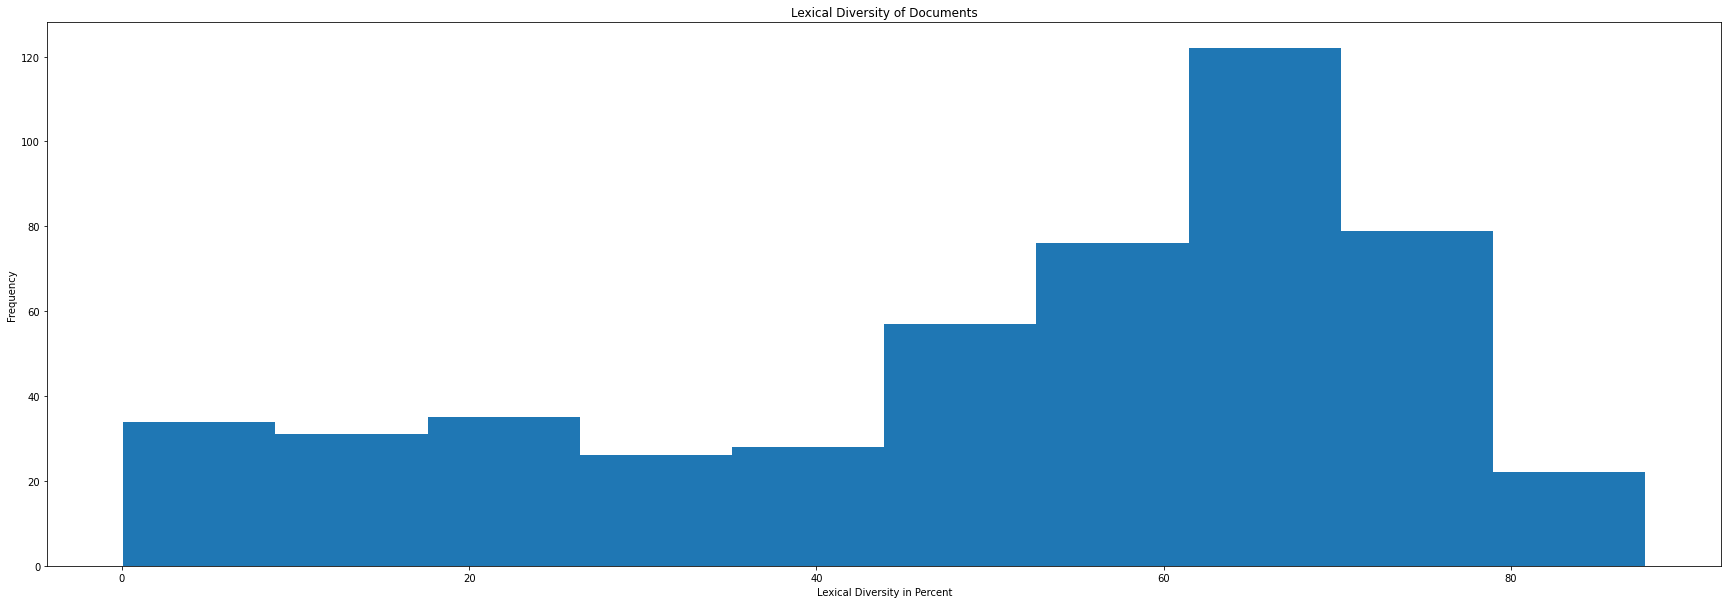

In [16]:
lexical_diversities = {u:lexical_diversity_percentage(doc) for (u, doc) in users_to_documents.items()}
lexical_div_df = pd.DataFrame.from_dict(lexical_diversities, orient='index', columns=['diversity'])
lexical_div_df.groupby('diversity')
plt.figure(1, figsize=(30, 10))
plt.title('Lexical Diversity of Documents')
plt.xlabel('Lexical Diversity in Percent')
lexical_div_df['diversity'].plot(kind='hist')

In [17]:
print(len(users_to_documents))
users_to_documents = {u:doc for (u, doc) in users_to_documents.items() if lexical_diversity_percentage(doc) >= 40}
len(users_to_documents)

510


375

In [18]:
users_to_documents_df = pd.DataFrame.from_dict(users_to_documents, orient='index')
users_to_documents_df

,0,1,2,3,4,5,6,7,8,9,...,2231,2232,2233,2234,2235,2236,2237,2238,2239,2240
ejsonkin,trip,end,homer,simpson,way,hear,lisa,grow,super,hot,...,None,None,None,None,None,None,None,None,None,None
ride_guru,uber,eats,become,ubers,successful,service,pictwittercomluewnucpv,drive,uber,trip,...,None,None,None,None,None,None,None,None,None,None
erikaabetts,get,sick,light,painting,drive,bridge,finish,uber,last,night,...,None,None,None,None,None,None,None,None,None,None
legalrideshare,accident,happen,make,sure,youre,prepared,put,together,stepbystep,list,...,None,None,None,None,None,None,None,None,None,None
fluperofficial,make,taxiserviceapps,one,aspect,fluper,master,read,full,blog,taxi,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
thebatimes,today,frontpage,may,bonadio,health,scare,pose,question,cuadernos,probe,...,None,None,None,None,None,None,None,None,None,None
pauldddaughters,uber,night,exchange,glance,travelalert,spoke,driver,waterloo,rank,conversation,...,None,None,None,None,None,None,None,None,None,None
iamalfr3do,disagree,accept,uber,pool,worth,majority,driver,speak,decline,pool,...,None,None,None,None,None,None,None,None,None,None
jenkers_en,uber,loses,billion,quarter,hit,forecast,revenue,rise,uber,ban,...,None,None,None,None,None,None,None,None,None,None


# Constructing the Term/Document Matrix

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
docs = users_to_documents.values()

In [21]:
def do_nothing(tokens):
    return tokens

vectorizer = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, min_df=0.3)

X = vectorizer.fit_transform(docs)

In [22]:
tf_idf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [23]:
tf_idf_df

,billion,business,car,company,day,drive,driver,get,ipo,like,...,price,public,ride,say,share,stock,take,time,uber,year
0,0.000000,0.000000,0.000000,0.000000,0.169264,0.171238,0.000000,0.000000,0.000000,0.147742,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.959270,0.000000
1,0.000000,0.023227,0.100839,0.038416,0.023494,0.023768,0.330434,0.017826,0.089949,0.000000,...,0.045932,0.046454,0.266610,0.000000,0.022218,0.023768,0.083714,0.022627,0.743419,0.023585
2,0.000000,0.000000,0.112615,0.000000,0.065595,0.132720,0.419343,0.248850,0.000000,0.171764,...,0.000000,0.000000,0.310151,0.000000,0.000000,0.000000,0.175294,0.000000,0.650557,0.065848
3,0.000000,0.187184,0.162531,0.154795,0.000000,0.000000,0.363129,0.143661,0.434938,0.000000,...,0.000000,0.000000,0.000000,0.165265,0.000000,0.000000,0.000000,0.000000,0.625943,0.190069
4,0.000000,0.486002,0.000000,0.200953,0.000000,0.000000,0.314274,0.000000,0.188211,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580424,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.249379,0.000000,0.000000,0.196818,0.000000,0.000000,0.307806,0.000000,0.460843,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.121774,0.000000,0.000000,0.568478,0.000000
371,0.000000,0.035204,0.061135,0.029113,0.000000,0.036025,0.398387,0.121585,0.054533,0.170951,...,0.017404,0.088011,0.000000,0.139869,0.000000,0.000000,0.063441,0.085738,0.849288,0.071494
372,0.000000,0.089213,0.232389,0.000000,0.000000,0.091293,0.634588,0.136939,0.000000,0.000000,...,0.088210,0.000000,0.085336,0.000000,0.000000,0.000000,0.080385,0.000000,0.681893,0.000000
373,0.225695,0.000000,0.133591,0.025447,0.062250,0.031488,0.218879,0.141697,0.405160,0.027168,...,0.030425,0.030771,0.029434,0.081503,0.117735,0.062976,0.027726,0.029976,0.793784,0.000000


## Performing a PCA

## Scale data

In [25]:
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.normalize(tf_idf_df), columns=tf_idf_df.columns)
data_scaled

,billion,business,car,company,day,drive,driver,get,ipo,like,...,price,public,ride,say,share,stock,take,time,uber,year
0,0.000000,0.000000,0.000000,0.000000,0.169264,0.171238,0.000000,0.000000,0.000000,0.147742,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.959270,0.000000
1,0.000000,0.023227,0.100839,0.038416,0.023494,0.023768,0.330434,0.017826,0.089949,0.000000,...,0.045932,0.046454,0.266610,0.000000,0.022218,0.023768,0.083714,0.022627,0.743419,0.023585
2,0.000000,0.000000,0.112615,0.000000,0.065595,0.132720,0.419343,0.248850,0.000000,0.171764,...,0.000000,0.000000,0.310151,0.000000,0.000000,0.000000,0.175294,0.000000,0.650557,0.065848
3,0.000000,0.187184,0.162531,0.154795,0.000000,0.000000,0.363129,0.143661,0.434938,0.000000,...,0.000000,0.000000,0.000000,0.165265,0.000000,0.000000,0.000000,0.000000,0.625943,0.190069
4,0.000000,0.486002,0.000000,0.200953,0.000000,0.000000,0.314274,0.000000,0.188211,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580424,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.249379,0.000000,0.000000,0.196818,0.000000,0.000000,0.307806,0.000000,0.460843,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.121774,0.000000,0.000000,0.568478,0.000000
371,0.000000,0.035204,0.061135,0.029113,0.000000,0.036025,0.398387,0.121585,0.054533,0.170951,...,0.017404,0.088011,0.000000,0.139869,0.000000,0.000000,0.063441,0.085738,0.849288,0.071494
372,0.000000,0.089213,0.232389,0.000000,0.000000,0.091293,0.634588,0.136939,0.000000,0.000000,...,0.088210,0.000000,0.085336,0.000000,0.000000,0.000000,0.080385,0.000000,0.681893,0.000000
373,0.225695,0.000000,0.133591,0.025447,0.062250,0.031488,0.218879,0.141697,0.405160,0.027168,...,0.030425,0.030771,0.029434,0.081503,0.117735,0.062976,0.027726,0.029976,0.793784,0.000000


## Perform the PCA

In [26]:
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(data_scaled)

In [40]:
len(X_reduced[:, 0])

375

## Analyze the percentage of explained variance per principal component

In [27]:
pd.DataFrame(pca.explained_variance_ratio_)

,0
0,0.187391
1,0.137229
2,0.087026
3,0.071278
4,0.051925
5,0.046681
6,0.044763
7,0.038714
8,0.034382
9,0.029749


## 2D Plot

Text(0.5, 1.0, '2D Plot')

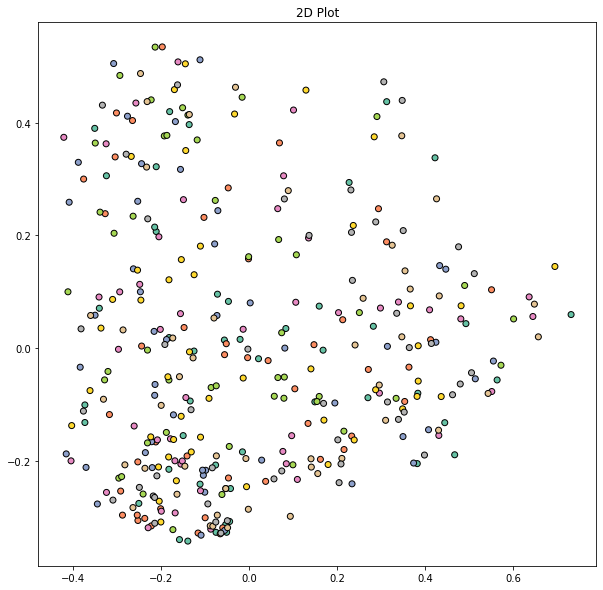

In [28]:
y = range(0, len(X_reduced))
plt.figure(1, figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set2, edgecolor='k')
plt.title('2D Plot')

## 3D Plot

Text(0.5, 0.92, 'PCA 3D Plot')

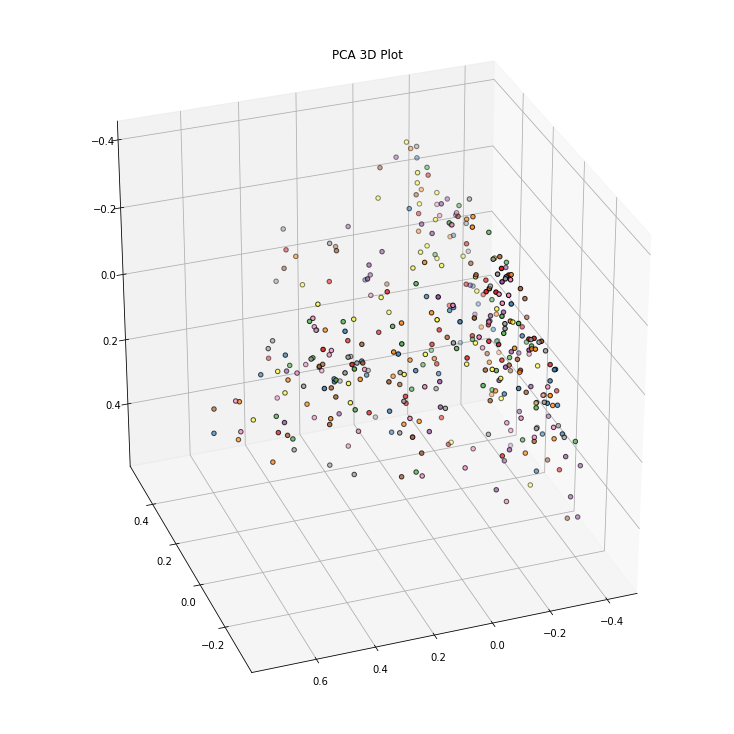

In [29]:
fig = plt.figure(1, figsize=(10, 10))
ax = Axes3D(fig, elev=-150, azim=110)
y = range(0, len(X_reduced))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k')
ax.set_title("PCA 3D Plot")

## See the documents/users with highest MSE

In [30]:
inverse_transform_data = pca.inverse_transform(X_reduced)
MSE_score = ((data_scaled-inverse_transform_data)**2).sum(axis=1)

In [31]:
MSE_max_scores = list(MSE_score.nlargest(10).index)

In [32]:
docs_with_highest_mse_df = users_to_documents_df.iloc[MSE_max_scores]
docs_with_highest_mse_df

,0,1,2,3,4,5,6,7,8,9,...,2231,2232,2233,2234,2235,2236,2237,2238,2239,2240
_nwaz,abandon,uber,three,day,left,hurry,immediately,polling,shut,mhbt,...,None,None,None,None,None,None,None,None,None,None
brookskcbsradio,bit,relief,bond,market,yield,nudge,high,lift,stock,dow,...,None,None,None,None,None,None,None,None,None,None
dataxevents,weekendupdate,shake,uber,innovation,sanfrancisco,realestate,data,game,teach,kid,...,None,None,None,None,None,None,None,None,None,None
astraldisaster4,look,like,airbnb,hard,time,public,uber,lyft,ipo,terrible,...,None,None,None,None,None,None,None,None,None,None
biereturtle,haha,pathetic,team,uber,wow,day,tweet,ceo,uber,support,...,None,None,None,None,None,None,None,None,None,None
adriancroydon,anyone,say,uber,safe,must,peculiar,childhood,police,expensive,unnessary,...,None,None,None,None,None,None,None,None,None,None
kaisharkyboi,know,get,uber,fulltime,quit,day,job,want,back,voiceacting,...,None,None,None,None,None,None,None,None,None,None
getibble,crypto,rise,flexa,allows,user,pay,major,retail,store,crypto,...,None,None,None,None,None,None,None,None,None,None
4abundantjoy,oann,say,drove,uber,smh,coverup,fbi,pictwittercomtslsadfms,solpais,drive,...,None,None,None,None,None,None,None,None,None,None
jennyhatch,twitter,thread,decision,drive,uber,lyft,strike,tomorrow,jennyhatch,uberlyftstrike,...,None,None,None,None,None,None,None,None,None,None


### See the length of the documents/users with highest MSE

In [33]:
usernames_with_highest_mse = list(docs_with_highest_mse_df.index)
lengths_of_docs_with_highest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_highest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_highest_mse_df

,count
jennyhatch,361
brookskcbsradio,340
adriancroydon,317
4abundantjoy,137
astraldisaster4,135
getibble,134
kaisharkyboi,125
biereturtle,124
dataxevents,121
_nwaz,116


## See the documents/users with the lowest MSE

In [34]:
MSE_low_scores = list(MSE_score.nsmallest(10).index)

In [35]:
docs_with_lowest_mse_df = users_to_documents_df.iloc[MSE_low_scores]
docs_with_lowest_mse_df

,0,1,2,3,4,5,6,7,8,9,...,2231,2232,2233,2234,2235,2236,2237,2238,2239,2240
rmawaters,amazon,invest,deliveroo,rival,uber,food,delivery,amazon,uber,promise,...,None,None,None,None,None,None,None,None,None,None
caseybecking,activityservice,dependency,rethink,android,architecture,uber,driver,app,uber,uberblog,...,None,None,None,None,None,None,None,None,None,None
pekalalaw,taxi,expensive,say,startup,uber,uber,driver,want,pay,extra,...,None,None,None,None,None,None,None,None,None,None
ratingsnetwork,ubers,loss,reach,despite,revenue,growth,uber,uber,earningsreports,earnings,...,None,None,None,None,None,None,None,None,None,None
marketbeatnews,ubers,loss,reach,despite,revenue,growth,uber,uber,earningsreports,earnings,...,None,None,None,None,None,None,None,None,None,None
ride_guru,uber,eats,become,ubers,successful,service,pictwittercomluewnucpv,drive,uber,trip,...,None,None,None,None,None,None,None,None,None,None
myjavain,uber,open,source,largescale,metric,platform,prometheus,opensource,grafana,mdb,...,None,None,None,None,None,None,None,None,None,None
bertrandduflos,uber,earnings,report,could,give,clearer,picture,selfdriving,car,uber,...,None,None,None,None,None,None,None,None,None,None
hacker_news_hir,uber,start,deactivate,rider,low,rating,uber,comment,price,fix,...,None,None,None,None,None,None,None,None,None,None
uberjustice,lyft,app,company,rdpartyassociates,responsible,anything,who,accountable,driver,injury,...,None,None,None,None,None,None,None,None,None,None


### See the length of the documents/users with lowest MSE

In [36]:
usernames_with_lowest_mse = list(docs_with_lowest_mse_df.index)
lengths_of_docs_with_lowest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_lowest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_lowest_mse_df

,count
uberjustice,724
ride_guru,598
ratingsnetwork,320
marketbeatnews,320
hacker_news_hir,294
pekalalaw,239
myjavain,196
caseybecking,195
rmawaters,173
bertrandduflos,163


In [37]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important_feature_indexes_per_pc = {}

initial_feature_names = data_scaled.columns

dfs = []

for pc in range(n_pcs):
    components_enumerated = list(enumerate(pca.components_[pc]))
    components_sorted = sorted(components_enumerated, key=lambda x:np.abs(x[1]), reverse=True)
    features_imps = {initial_feature_names[i]:imp for (i, imp) in components_sorted}
    features_imps_df = pd.DataFrame.from_dict(features_imps, orient='index', columns = ['importance'] )[:20]
    dfs.append(features_imps_df)
    
i = 1
for df in dfs:
    print('PCA %d' % i)
    print(df)
    print('')
    i += 1

PCA 1
         importance
ipo        0.726321
driver    -0.443656
stock      0.220455
billion    0.173769
price      0.157028
ride      -0.148750
get       -0.148046
market     0.142608
lyft      -0.135423
drive     -0.130894
share      0.115107
car       -0.109753
uber      -0.104847
public     0.097070
take      -0.076116
like      -0.067745
company    0.058985
year       0.058876
make      -0.048704
time      -0.047631

PCA 2
          importance
lyft        0.898067
uber       -0.369787
car         0.098253
ipo         0.090694
ride        0.087210
day        -0.081047
stock       0.077398
say        -0.061928
driver     -0.057054
make       -0.054413
like       -0.047790
drive       0.032942
business   -0.032578
year       -0.031894
market      0.028567
one        -0.025302
public     -0.021649
new         0.018925
get        -0.017143
price      -0.014292

PCA 3
          importance
driver      0.730379
uber       -0.514843
ipo         0.215473
lyft       -0.193679
stock       0.

In [ ]:
from sklearn.cluster import KMeans

